# Sklearn
Notebook pensando para facilitar e agiliar o treinamento de Machine Learning, sendo necessário, em grande parte das vezes, somente alterar o caminho do dataset e o tipo (classificador ou regressão).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import copy
import json
import math
import time
import pickle

import pandas as pd
from sklearn.preprocessing import LabelEncoder

## Preparar Dataset

In [2]:
def preprocess_data(df, target_cols, max_unique_values=10, window_size=1, no_columns_lags=[]):
    """
    Preprocess dataset, converting string columns to number and identifying numeric, categorical, and date columns.
    Adds a window of historical rows to the data.

    Args:
        df (DataFrame): DataFrame with data to analyze.
        target_cols (list): All target columns to not add in numeric, categorical, or date feature lists.
        max_unique_values (int): Maximum number of unique values to consider a numeric column as categorical.
        window_size (int): Number of previous rows to include for each row.
        no_columns_lags (list): Columns names to not do lags, keeping only the current one.

    Returns:
        df_copy (DataFrame): Processed DataFrame with transformations applied.
        num_col_names (list): List of numeric feature column names.
        cat_col_names (list): List of categorical feature column names.
        date_col_names (list): List of date feature column names.
        mappings (dict): Mapping of original categorical values (or target columns) to transformed numeric values.
    """
    # Create a copy so as not to alter the original DataFrame
    df_copy = df.copy()

    # Remove lines with null values
    df_copy = df_copy.dropna()
    
    # Identify categorical and numeric columns
    cat_col_names = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    num_col_names = df_copy.select_dtypes(include=['number']).columns.tolist()
    date_col_names = []

    # Identify columns that are dates
    for col in df.columns:
        if df[col].dtype in ['object', 'string']:  # Only check object/string columns
            try:
                # Attempt to convert the column to datetime
                df_copy[col] = pd.to_datetime(df[col], errors='raise').astype(int) // 10**9
                if col not in target_cols:  # Avoid considering target columns as date columns
                    date_col_names.append(col)
            except (ValueError, TypeError):
                pass

    # Identify numeric columns that are categorical
    potential_categorical = []
    for col in num_col_names:
        if col not in target_cols and df_copy[col].nunique() <= max_unique_values:
            potential_categorical.append(col)

    cat_col_names += potential_categorical

    # Remove target columns from the lists
    num_col_names = [col for col in num_col_names if col not in potential_categorical + target_cols + date_col_names]
    cat_col_names = [col for col in cat_col_names if col not in target_cols + date_col_names]
    
    mappings = {}
    label_encoders = {}

    # Convert string columns to category and create a mapping (old value -> new value)
    for col in cat_col_names + target_cols:
        if df_copy[col].dtype not in ['int64', 'float64']:
            le = LabelEncoder()
            df_copy[col] = le.fit_transform(df_copy[col])
            mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
            label_encoders[col] = le
            # Convert values to int (otherwise will raise error if save as json)
            for key, value in mappings[col].items():
                mappings[col][key] = int(value)
        #else:
        #    mappings[col] = {int(val): int(val) for val in df_copy[col].unique()}

    # Add historical data based on window_size
    if window_size > 1:
        historical_features = []
        for i in range(window_size - 1, 0, -1):  # Create features lag, oldest to newest
            shifted = df_copy.drop(columns=target_cols + no_columns_lags, errors='ignore').shift(i).add_suffix(f'_lag_{i}')
            historical_features.append(shifted)
        
        # Concatenate the lags to the left and keep the current values
        df_copy = pd.concat(historical_features + [df_copy], axis=1)

        # Remove NaNs columns created by shifts
        df_copy = df_copy.dropna()
    
        # Add lags
        num_col_lags = [f'{col}_lag_{i}' for i in range(window_size - 1, 0, -1) for col in num_col_names if col not in no_columns_lags]
        cat_col_lags = [f'{col}_lag_{i}' for i in range(window_size - 1, 0, -1) for col in cat_col_names if col not in no_columns_lags]
        date_col_lags = [f'{col}_lag_{i}' for i in range(window_size - 1, 0, -1) for col in date_col_names if col not in no_columns_lags]
        mappings_lags = {}
        for col, value in mappings.items():
            for i in range(window_size - 1, 0, -1):
                mappings_lags[f'{col}_lag_{i}'] = value
    
        # Update main columns + lags columns
        num_col_names = num_col_lags + num_col_names
        cat_col_names = cat_col_lags + cat_col_names
        date_col_names = date_col_lags + date_col_names
        mappings = {**mappings_lags, **mappings}
    
    return df_copy, num_col_names, cat_col_names, date_col_names, mappings

In [3]:
df = pd.read_csv('dataset/time_series_temperature.csv')
model_type = 'regressor'  # classifier or regressor
window_size = 3  # Greater than 1 for temporal data
no_columns_lags = ['data']  # Only for temporal data. Otherwise keep the list empty
temporal_test_part = 2  # Which part of the dataset uses to test. 0 == random; 1 == begin; 2 == end
target_cols = ['target']  # Target column
df

,data,temperature,atmospheric_pressure,humidity,wind_speed,target
0,2025-01-03,29.204468,1018.531025,55.368863,5.636536,12.745888
1,2025-01-04,22.318149,1017.262825,38.066587,2.520635,14.497671
2,2025-01-05,18.386458,994.651252,57.438279,9.802986,12.170944
3,2025-01-06,29.625662,1029.142441,88.232424,14.553119,10.076645
4,2025-01-07,13.901379,1005.326379,37.854832,12.765371,8.582377
...,...,...,...,...,...,...
993,2027-09-23,28.789072,1003.400658,67.593622,11.953912,9.325243
994,2027-09-24,27.887713,1012.916262,50.098965,2.210093,12.846413
995,2027-09-25,16.830046,988.167754,77.374936,14.168634,10.899380
996,2027-09-26,12.307704,990.774392,56.353575,18.602596,6.143613


In [4]:
# Preprocess data
df, num_col_names, cat_col_names, date_col_names, category_mappings = preprocess_data(df, target_cols, max_unique_values=10, window_size=window_size, no_columns_lags=no_columns_lags)
col_names_order = df.columns.tolist()

In [5]:
df

,temperature_lag_2,atmospheric_pressure_lag_2,humidity_lag_2,wind_speed_lag_2,temperature_lag_1,atmospheric_pressure_lag_1,humidity_lag_1,wind_speed_lag_1,data,temperature,atmospheric_pressure,humidity,wind_speed,target
2,29.204468,1018.531025,55.368863,5.636536,22.318149,1017.262825,38.066587,2.520635,1736035200,18.386458,994.651252,57.438279,9.802986,12.170944
3,22.318149,1017.262825,38.066587,2.520635,18.386458,994.651252,57.438279,9.802986,1736121600,29.625662,1029.142441,88.232424,14.553119,10.076645
4,18.386458,994.651252,57.438279,9.802986,29.625662,1029.142441,88.232424,14.553119,1736208000,13.901379,1005.326379,37.854832,12.765371,8.582377
5,29.625662,1029.142441,88.232424,14.553119,13.901379,1005.326379,37.854832,12.765371,1736294400,24.173470,990.590026,41.027570,12.433600,12.463849
6,13.901379,1005.326379,37.854832,12.765371,24.173470,990.590026,41.027570,12.433600,1736380800,19.105578,1022.114411,36.760806,18.049986,10.954051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,26.676370,1022.415136,59.614973,16.943906,10.946224,1017.197600,68.560684,8.132820,1821657600,28.789072,1003.400658,67.593622,11.953912,9.325243
994,10.946224,1017.197600,68.560684,8.132820,28.789072,1003.400658,67.593622,11.953912,1821744000,27.887713,1012.916262,50.098965,2.210093,12.846413
995,28.789072,1003.400658,67.593622,11.953912,27.887713,1012.916262,50.098965,2.210093,1821830400,16.830046,988.167754,77.374936,14.168634,10.899380
996,27.887713,1012.916262,50.098965,2.210093,16.830046,988.167754,77.374936,14.168634,1821916800,12.307704,990.774392,56.353575,18.602596,6.143613


In [6]:
print(f'''col_names_order: {col_names_order}
num_col_names: {num_col_names}
cat_col_names: {cat_col_names}
date_col_names: {date_col_names}
target_cols: {target_cols}
category_mappings: {category_mappings}''')

col_names_order: ['temperature_lag_2', 'atmospheric_pressure_lag_2', 'humidity_lag_2', 'wind_speed_lag_2', 'temperature_lag_1', 'atmospheric_pressure_lag_1', 'humidity_lag_1', 'wind_speed_lag_1', 'data', 'temperature', 'atmospheric_pressure', 'humidity', 'wind_speed', 'target']
num_col_names: ['temperature_lag_2', 'atmospheric_pressure_lag_2', 'humidity_lag_2', 'wind_speed_lag_2', 'temperature_lag_1', 'atmospheric_pressure_lag_1', 'humidity_lag_1', 'wind_speed_lag_1', 'temperature', 'atmospheric_pressure', 'humidity', 'wind_speed']
cat_col_names: []
date_col_names: ['data']
target_cols: ['target']
category_mappings: {}


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 2 to 997
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   temperature_lag_2           996 non-null    float64
 1   atmospheric_pressure_lag_2  996 non-null    float64
 2   humidity_lag_2              996 non-null    float64
 3   wind_speed_lag_2            996 non-null    float64
 4   temperature_lag_1           996 non-null    float64
 5   atmospheric_pressure_lag_1  996 non-null    float64
 6   humidity_lag_1              996 non-null    float64
 7   wind_speed_lag_1            996 non-null    float64
 8   data                        996 non-null    int64  
 9   temperature                 996 non-null    float64
 10  atmospheric_pressure        996 non-null    float64
 11  humidity                    996 non-null    float64
 12  wind_speed                  996 non-null    float64
 13  target                      996 non-null

In [8]:
if model_type == 'classifier':
    print(df[target_cols].value_counts())

### Dataset Split

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

train, test = train_test_split(df, random_state=42, test_size=0.3)

if window_size > 1:
    # Get first part of the dataset for test
    if temporal_test_part == 1:
        train = df.iloc[:int(len(df)*0.3)]
        train = shuffle(train, random_state=42)
        test = df.iloc[int(len(df)*0.3):]
    # Get last part of the dataset for test
    elif temporal_test_part == 2:
        train = df.iloc[:int(len(df)*0.7)]
        train = shuffle(train, random_state=42)
        test = df.iloc[int(len(df)*0.7):]

In [10]:
y_train = train[target_cols]
x_train = train.drop(target_cols, axis=1)

In [11]:
y_test = test[target_cols]
x_test = test.drop(target_cols, axis=1)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [13]:
#from skelarn.preprocessing import MinMaxScaler

#scaler = preprocessing.MinMaxScaler()

In [14]:
x_train

,temperature_lag_2,atmospheric_pressure_lag_2,humidity_lag_2,wind_speed_lag_2,temperature_lag_1,atmospheric_pressure_lag_1,humidity_lag_1,wind_speed_lag_1,data,temperature,atmospheric_pressure,humidity,wind_speed
160,19.896108,981.843404,68.426465,1.807610,24.925605,1020.323242,31.711203,10.673051,1749686400,27.863230,982.525893,63.801928,9.083621
499,15.265726,1016.268544,52.421635,10.803885,28.956320,1003.066693,57.996864,13.307716,1778976000,25.389537,1029.803245,54.574362,9.752135
397,21.193393,987.922220,70.454872,13.339209,23.575029,1015.667173,68.459813,17.584157,1770163200,16.526745,1006.280674,85.923733,6.350102
157,14.019939,1015.800780,43.693244,14.098339,13.993246,1009.516868,55.043601,16.018558,1749427200,23.385722,1005.486687,68.897769,18.086136
323,16.865377,1005.328230,42.967926,1.789045,11.985979,1011.577320,41.250436,1.161364,1763769600,11.522224,1013.823791,41.428044,11.672949
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,22.804534,986.517903,84.836968,8.547070,11.341251,1014.045467,33.255625,15.247649,1742169600,16.213109,1023.135977,75.683038,5.404471
108,26.319418,1026.624365,44.655492,9.019665,27.839426,1004.355025,38.214743,17.693443,1745193600,25.764761,989.168588,60.846891,8.526223
272,13.686724,985.046995,44.838549,18.886910,28.785689,1028.324998,65.927011,16.656633,1759363200,26.649485,1023.633639,36.592835,7.411725
437,10.306918,1015.962999,53.680541,7.409775,23.841495,987.021255,81.811254,17.282881,1773619200,12.585329,994.756855,77.995033,13.001234


In [15]:
x_train[num_col_names] = scaler.fit_transform(x_train[num_col_names])
x_train = x_train.values.tolist()
x_train

[[-0.01302354884638623,
  -1.6919823116809463,
  0.5235174362248355,
  -1.4929756774591356,
  0.845178117143607,
  1.0031663999550586,
  -1.6417476723656663,
  0.07397616869488374,
  1749686400.0,
  1.3413561745226181,
  -1.6420058658436913,
  0.24950183875504459,
  -0.21071369628234088],
 [-0.7989026258623733,
  0.7172134638538871,
  -0.4219358396823608,
  0.09658005864893485,
  1.5296581399417235,
  -0.2050894079845413,
  -0.09090718460557953,
  0.5392358578353584,
  1778976000.0,
  0.921727326951502,
  1.6692146892988866,
  -0.2954950835696261,
  -0.09268005934570933],
 [0.20715477372498595,
  -1.2665647739086283,
  0.6433414918035895,
  0.5445476697271479,
  0.6158286162624164,
  0.6771613209489361,
  0.5264014374677108,
  1.294419510803609,
  1770163200.0,
  -0.5817266568869617,
  0.02173619852406141,
  1.5560561969837687,
  -0.6933476056837194],
 [-1.010340431650813,
  0.6844776737273773,
  -0.9375480708432992,
  0.6786786230911152,
  -1.0113116572073801,
  0.2465340083293369,
  

In [16]:
x_test[num_col_names] = scaler.transform(x_test[num_col_names])
x_test = x_test.values.tolist()
x_test

[[-1.3029533097167298,
  -0.3155203579200086,
  -1.3420648770569676,
  -1.2029867122957856,
  1.2799226780518171,
  -0.45529779141236093,
  0.3712607501308026,
  1.4543660792107902,
  1796256000.0,
  -0.9302832634595462,
  -0.7183818546966878,
  1.0740229839198503,
  0.398575111804636],
 [1.2750990736204555,
  -0.45678806510788816,
  0.3701534241799101,
  1.454625447250934,
  -0.930008187755192,
  -0.7199518439956923,
  1.0752393607273025,
  0.40268932435265686,
  1796342400.0,
  0.32193834226129514,
  0.5140645695865892,
  1.413305803151964,
  -0.038644988818313845],
 [-0.9336122980981445,
  -0.7213150627046089,
  1.0750091882746364,
  0.40236010929379085,
  0.3235378620135044,
  0.5121256190359719,
  1.414164026886776,
  -0.034605640115474685,
  1796428800.0,
  -0.6534367604684743,
  -0.9993182669415084,
  -1.5406769490419758,
  -0.8041958517632669],
 [0.3192420141954598,
  0.5101709051882477,
  1.4143561527143163,
  -0.03517959237536658,
  -0.6528688710150353,
  -1.0008041514484156,

### Variáveis de entrada mais importantes para as tomadas de decisão do modelo

#### Random Forest

In [17]:
if model_type == 'classifier':
    from sklearn.ensemble import RandomForestClassifier
    
    # Realizando Random Forest para identificar a relevância das variáveis.
    # Feature Extraction by Random Forest
    model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                           criterion='gini', max_depth=None, max_features=3, # nao sei o que eh este max_features
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_jobs=None, oob_score=False, random_state=None,
                           verbose=0, warm_start=False)
    model.fit(x_train, y_train)
    
    feature_importances_val = model.feature_importances_
    pd.options.display.float_format = '{:.10f}'.format
    
    x_pd = pd.DataFrame(x_train, columns=col_names_order[:-1])
    feature_importances = pd.DataFrame(feature_importances_val,
                                       index = x_pd.columns,
                                       columns=['importance']).sort_values('importance', ascending = False)
    print(f'Accuracy: {model.score(x_test, y_test) * 100}')
    print(feature_importances)

#### DecisionTree

MSE: 6.53416319048907
0-temperature_lag_2, Score: 0.068019450131539
1-atmospheric_pressure_lag_2, Score: 0.0
2-humidity_lag_2, Score: 0.0
3-wind_speed_lag_2, Score: 0.0
4-temperature_lag_1, Score: 0.2961292685234597
5-atmospheric_pressure_lag_1, Score: 0.0
6-humidity_lag_1, Score: 0.0
7-wind_speed_lag_1, Score: 0.0
8-data, Score: 0.0
9-temperature, Score: 0.5623503417027282
10-atmospheric_pressure, Score: 0.0
11-humidity, Score: 0.07350093964227312
12-wind_speed, Score: 0.0


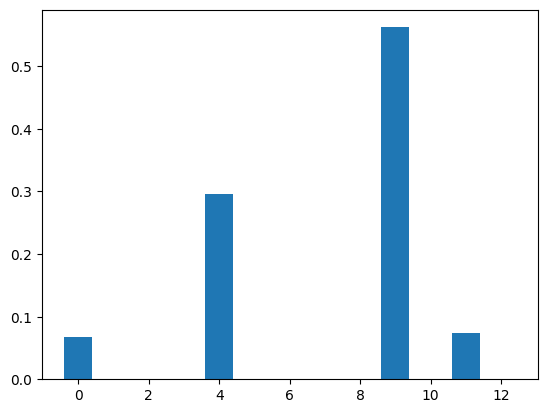

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


if model_type == 'classifier':
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import confusion_matrix
    model = DecisionTreeClassifier(max_depth=3)
else:
    from sklearn.tree import DecisionTreeRegressor
    model = DecisionTreeRegressor(max_depth=3)    

model.fit(x_train, y_train)

if model_type == 'classifier':
    print(f'Accuracy: {model.score(x_test, y_test) * 100}')
    print(f'Confusion matrix: {confusion_matrix(model.predict(x_test), y_test)}')
else:
    print(f'MSE: {mean_squared_error(model.predict(x_test), y_test)}')

importance = model.feature_importances_
for idx, score in enumerate(importance):
    print(f'{idx}-{df.keys()[idx]}, Score: {score}')

plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Treinar diversos estimators disponíveis no Sklearn
https://scikit-learn.org/stable/supervised_learning.html

In [19]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.discovery.all_estimators.html#sklearn.utils.discovery.all_estimators
from sklearn.utils import all_estimators

# classifier, regressor, cluster, transformer
estimators = all_estimators(type_filter=model_type)

all_estimators = {}
for name, estimator in estimators:
    try:
        print('Appending', name)
        est = estimator()
        all_estimators[name] = est
    except Exception as e:
        print(e)

Appending ARDRegression
Appending AdaBoostRegressor
Appending BaggingRegressor
Appending BayesianRidge
Appending CCA
Appending DecisionTreeRegressor
Appending DummyRegressor
Appending ElasticNet
Appending ElasticNetCV
Appending ExtraTreeRegressor
Appending ExtraTreesRegressor
Appending GammaRegressor
Appending GaussianProcessRegressor
Appending GradientBoostingRegressor
Appending HistGradientBoostingRegressor
Appending HuberRegressor
Appending IsotonicRegression
Appending KNeighborsRegressor
Appending KernelRidge
Appending Lars
Appending LarsCV
Appending Lasso
Appending LassoCV
Appending LassoLars
Appending LassoLarsCV
Appending LassoLarsIC
Appending LinearRegression
Appending LinearSVR
Appending MLPRegressor
Appending MultiOutputRegressor
MultiOutputRegressor.__init__() missing 1 required positional argument: 'estimator'
Appending MultiTaskElasticNet
Appending MultiTaskElasticNetCV
Appending MultiTaskLasso
Appending MultiTaskLassoCV
Appending NuSVR
Appending OrthogonalMatchingPursuit


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

def run_sklearn_estimators(estimators, x_train, y_train, x_test, y_test, model_type='classifier'):
    if model_type == 'classifier':
        best_acc = ['', 0.0]  # [estimator_name, accuracy]
    else:
        best_acc = ['', 99999.0]  # [estimator_name, error]
    
    for estimator_name, estimator in estimators.items():
        try:
            print(f'##### {estimator_name} #####')

            estimator.fit(x_train, y_train)
            
            if model_type == 'classifier':
                print('Train ACC: %.3f%%' % (estimator.score(x_train, y_train) * 100.00))
            else:
                train_mse = mean_squared_error(estimator.predict(x_train), y_train)
                print('Train MSE: %.3f' % (train_mse))
                print(f'Train inference error (RMSE): ±{math.sqrt(train_mse)}')
            
            if model_type == 'classifier':
                test_acc = estimator.score(x_test, y_test) * 100.00
                print('Test ACC: %.3f%%' % (test_acc))
            else:
                test_mse = mean_squared_error(estimator.predict(x_test), y_test)
                print('Test MSE: %.3f' % (test_mse))
                print(f'Test inference error (RMSE): ±{math.sqrt(test_mse)}')
            print()
    
            if model_type == 'classifier' and test_acc > best_acc[1]:
                best_acc = [estimator_name, test_acc]
            elif model_type == 'regressor' and test_mse < best_acc[1]:
                best_acc = [estimator_name, test_mse, math.sqrt(test_mse)]
            
            # Confusion Matrix
            if model_type == 'classifier':
                preds = estimator.predict(x_test)
                matrix = confusion_matrix(y_test, preds)
                print('Confusion Matrix Test:')
                print(matrix)
        except Exception as e:
            print(f'Error ({estimator_name}): {e}')

    print('########## Best Estimator ##########')
    print(best_acc)
    
    return estimators, best_acc[0]

In [21]:
tic = time.time()
estimators_trained, best_estimator_name = run_sklearn_estimators(
    all_estimators,
    x_train,
    y_train,
    x_test,
    y_test,
    model_type
)
print(f'Total time: {time.time() - tic}')

##### ARDRegression #####
Train MSE: 0.000
Train inference error (RMSE): ±9.072580611137334e-11
Test MSE: 0.000
Test inference error (RMSE): ±8.774720143308365e-11

##### AdaBoostRegressor #####
Train MSE: 1.502
Train inference error (RMSE): ±1.2254829481739766
Test MSE: 2.419
Test inference error (RMSE): ±1.555308469371337

##### BaggingRegressor #####
Train MSE: 0.372
Train inference error (RMSE): ±0.6095728205590261
Test MSE: 2.054
Test inference error (RMSE): ±1.4331813918421108

##### BayesianRidge #####
Train MSE: 0.000
Train inference error (RMSE): ±5.790525644301764e-10
Test MSE: 0.000
Test inference error (RMSE): ±7.673700966354142e-10

##### CCA #####
Error (CCA): `n_components` upper bound is 1. Got 2 instead. Reduce `n_components`.
##### DecisionTreeRegressor #####
Train MSE: 0.000
Train inference error (RMSE): ±0.0
Test MSE: 4.322
Test inference error (RMSE): ±2.07903134279667

##### DummyRegressor #####
Train MSE: 14.027
Train inference error (RMSE): ±3.7453180260261307
T

In [22]:
estimators_trained[best_estimator_name]

ARDRegression()

### Save Estimator

In [23]:
# Save
pickle.dump(estimators_trained[best_estimator_name], open('results/estimator_sklearn.sav', 'wb'))

# Scaler
pickle.dump(scaler, open('results/scaler.pkl','wb'))

# Save columns names and informations
data_to_save = {
    'col_names_order': col_names_order,
    'num_col_names': num_col_names,
    'cat_col_names': cat_col_names,
    'date_col_names': date_col_names,
    'target_cols': target_cols,
    'category_mappings': category_mappings,
    'window_size': window_size
}
with open('results/columns_metadata_sklearn.json', 'w') as json_file:
    json.dump(data_to_save, json_file, indent=4)

## Stacking estimators
Classificador: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier

Regressor: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor

In [24]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.discovery.all_estimators.html#sklearn.utils.discovery.all_estimators
from sklearn.utils import all_estimators

# classifier, regressor, cluster, transformer
estimators = all_estimators(type_filter=model_type)

all_estimators = {}
for name, estimator in estimators:
    try:
        print('Appending', name)
        est = estimator()
        all_estimators[name] = est
    except Exception as e:
        print(e)

Appending ARDRegression
Appending AdaBoostRegressor
Appending BaggingRegressor
Appending BayesianRidge
Appending CCA
Appending DecisionTreeRegressor
Appending DummyRegressor
Appending ElasticNet
Appending ElasticNetCV
Appending ExtraTreeRegressor
Appending ExtraTreesRegressor
Appending GammaRegressor
Appending GaussianProcessRegressor
Appending GradientBoostingRegressor
Appending HistGradientBoostingRegressor
Appending HuberRegressor
Appending IsotonicRegression
Appending KNeighborsRegressor
Appending KernelRidge
Appending Lars
Appending LarsCV
Appending Lasso
Appending LassoCV
Appending LassoLars
Appending LassoLarsCV
Appending LassoLarsIC
Appending LinearRegression
Appending LinearSVR
Appending MLPRegressor
Appending MultiOutputRegressor
MultiOutputRegressor.__init__() missing 1 required positional argument: 'estimator'
Appending MultiTaskElasticNet
Appending MultiTaskElasticNetCV
Appending MultiTaskLasso
Appending MultiTaskLassoCV
Appending NuSVR
Appending OrthogonalMatchingPursuit


In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

def run_sklearn_estimators_with_stacking(estimators, x_train, y_train, x_test, y_test, model_type):
    if model_type == 'classifier':
        best_acc = ['', 0.0]  # [estimator_name, accuracy]
    else:
        best_acc = ['', 99999.0]  # [estimator_name, error]
    estimators_stacked_trained = {}
    
    idx = 0
    for estimator_name, estimator in estimators.items():
        count = 0
        for estimator_name2, estimator2 in estimators.items():
            if count <= idx:
                count += 1
                continue
            try:
                print(f'##### {estimator_name} - {estimator_name2} #####')

                if model_type == 'classifier':
                    stack = StackingClassifier([(estimator_name, copy.deepcopy(estimator)), (estimator_name2, copy.deepcopy(estimator2))],
                                              final_estimator=LogisticRegression())
                else:
                    stack = StackingRegressor([(estimator_name, copy.deepcopy(estimator)), (estimator_name2, copy.deepcopy(estimator2))],
                                              final_estimator=RidgeCV())

                stack.fit(x_train, y_train)
                
                if model_type == 'classifier':
                    print('Train ACC: %.3f%%' % (stack.score(x_train, y_train) * 100.00))
                else:
                    train_mse = mean_squared_error(stack.predict(x_train), y_train)
                    print('Train MSE: %.3f' % (train_mse))
                    print(f'Train inference error (RMSE): ±{math.sqrt(train_mse)}')
                
                if model_type == 'classifier':
                    test_acc = stack.score(x_test, y_test) * 100.00
                    print('Test ACC: %.3f%%' % (test_acc))
                else:
                    test_mse = mean_squared_error(stack.predict(x_test), y_test)
                    print('Test MSE: %.3f' % (test_mse))
                    print(f'Test inference error (RMSE): ±{math.sqrt(test_mse)}')
        
                if model_type == 'classifier' and test_acc > best_acc[1]:
                    best_acc = [f'{estimator_name}-{estimator_name2}', test_acc]
                elif model_type == 'regressor' and test_mse < best_acc[1]:
                    best_acc = [f'{estimator_name}-{estimator_name2}', test_mse, math.sqrt(test_mse)]
                
                # Confusion Matrix
                if model_type == 'classifier':
                    preds = stack.predict(x_test)
                    matrix = confusion_matrix(y_test, preds)
                    print('Confusion Matrix Test:')
                    print(matrix)

                estimators_stacked_trained[f'{estimator_name}-{estimator_name2}'] = copy.deepcopy(stack)
            except Exception as e:
                print(f'Error ({estimator_name}-{estimator_name2}): {e}')
                continue
        
        idx += 1

    print('########## Best Estimator ##########')
    print(best_acc)
    
    return estimators_stacked_trained, best_acc[0]

In [26]:
tic = time.time()
estimators_stacked_trained, best_staked_estimator_name = run_sklearn_estimators_with_stacking(
    all_estimators,
    x_train,
    y_train,
    x_test,
    y_test,
    model_type
)
print(f'Total time: {time.time() - tic}')

##### ARDRegression - AdaBoostRegressor #####
Train MSE: 0.000
Train inference error (RMSE): ±0.007145519267246555
Test MSE: 0.000
Test inference error (RMSE): ±0.007544558790018069
##### ARDRegression - BaggingRegressor #####
Train MSE: 0.000
Train inference error (RMSE): ±0.007064339964963458
Test MSE: 0.000
Test inference error (RMSE): ±0.007362467467989793
##### ARDRegression - BayesianRidge #####
Train MSE: 0.000
Train inference error (RMSE): ±0.0002190099344806881
Test MSE: 0.000
Test inference error (RMSE): ±0.00023259554974214614
##### ARDRegression - CCA #####
Error (ARDRegression-CCA): `n_components` upper bound is 1. Got 2 instead. Reduce `n_components`.
##### ARDRegression - DecisionTreeRegressor #####
Train MSE: 0.000
Train inference error (RMSE): ±0.006251765352825974
Test MSE: 0.000
Test inference error (RMSE): ±0.0077398571086248515
##### ARDRegression - DummyRegressor #####
Train MSE: 0.000
Train inference error (RMSE): ±0.007063322546256342
Test MSE: 0.000
Test infere

In [27]:
estimators_stacked_trained[best_staked_estimator_name]

StackingRegressor(estimators=[('BayesianRidge', BayesianRidge()),
                              ('TheilSenRegressor', TheilSenRegressor())],
                  final_estimator=RidgeCV())

### Save Estimator staked

In [28]:
# Save
pickle.dump(estimators_trained[best_estimator_name], open('results/estimator_sklearn_stacked.sav', 'wb'))

# Scaler
pickle.dump(scaler, open('results/scaler.pkl','wb'))

# Save columns names and informations
data_to_save = {
    'col_names_order': col_names_order,
    'num_col_names': num_col_names,
    'cat_col_names': cat_col_names,
    'date_col_names': date_col_names,
    'target_cols': target_cols,
    'category_mappings': category_mappings,
    'window_size': window_size
}
with open('results/columns_metadata_sklearn_stacked.json', 'w') as json_file:
    json.dump(data_to_save, json_file, indent=4)

## Predict

In [29]:
import json
import pickle

import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [30]:
# Load
loaded_estimator = pickle.load(open('results/estimator_sklearn_stacked.sav', 'rb'))
# Scaler
loaded_scaler = pickle.load(open('results/scaler.pkl','rb'))
# columns_metadata
columns_metadata = json.load(open('results/columns_metadata_sklearn_stacked.json', 'r'))

In [31]:
def preprocess_inference_data(new_input, columns_metadata, scaler=None):
    """
    Preprocess the input data for inference based on metadata and scaler for numeric normalization.

    Args:
        new_input (list of list): Data to preprocess (each inner list is a row).
        columns_metadata (dict): Metadata defining column names, types, mappings, and order.
        scaler (StandardScaler): Trained scaler for numerical columns.
    
    Returns:
        list: Preprocessed data ready for inference.
    """
    # Exclude target columns from col_names_order for inference
    target_cols = columns_metadata['target_cols']
    col_names_order = [col for col in columns_metadata['col_names_order'] if col not in target_cols]
    # Transform the new_input into a DataFrame with the correct column order
    df_input = pd.DataFrame(new_input, columns=col_names_order)

    # Convert categorical columns based on category_mappings
    category_mappings = columns_metadata['category_mappings']
    for col in columns_metadata['cat_col_names']:
        if col in df_input.columns and col in category_mappings:
            # Replace string categories with mapped integer IDs
            df_input[col] = df_input[col].map(category_mappings[col])
            if df_input[col].isnull().any():
                raise ValueError(f'Invalid value found in column "{col}" that is not in the category mappings.')

    # Normalize numeric columns using the trained scaler
    num_col_names = columns_metadata['num_col_names']
    if num_col_names and scaler:
        df_input[num_col_names] = scaler.transform(df_input[num_col_names])

    # Ensure date columns are in the correct datetime format
    for col in columns_metadata['date_col_names']:
        if col in df_input.columns:
            df_input[col] = pd.to_datetime(df_input[col], errors='coerce').astype(int) // 10**9
            if df_input[col].isnull().any():
                raise ValueError(f'Invalid date value found in column "{col}".')

    # Drop target columns if they exist in the input (not used in inference)
    target_cols = columns_metadata['target_cols']
    df_input = df_input.drop(columns=target_cols, errors='ignore')

    # Convert DataFrame to list of rows for model inference
    processed_data = df_input.values.tolist()

    return processed_data

**ATENÇÃO:** Modifique a variável "new_input" conforme o seu dataset.

In [32]:
# Predictions
new_input = [
    [16.104017, 991.702137, 33.491679, 5.722285, 26.064810, 992.934297, 58.463331, 16.400403, '2026-12-07', 15.764825, 997.960562, 85.419949, 1.430146]
]
new_input_preprocessed = preprocess_inference_data(new_input, columns_metadata, loaded_scaler)
new_input_preprocessed

[[-0.6566259610493973,
  -1.0020325387672895,
  -1.54018511120959,
  -0.8012900629047318,
  1.0386334016719143,
  -0.9145317195800292,
  -0.06338586865109594,
  1.0853784867264844,
  1796601600.0,
  -0.7109761886219765,
  -0.5609894513544795,
  1.5263017672739743,
  -1.5620218399366994]]

In [34]:
tic = time.time()
print(loaded_estimator.predict(new_input_preprocessed))
print(f'Total time: {time.time() - tic}')

[7.3786154]
Total time: 0.0002663135528564453


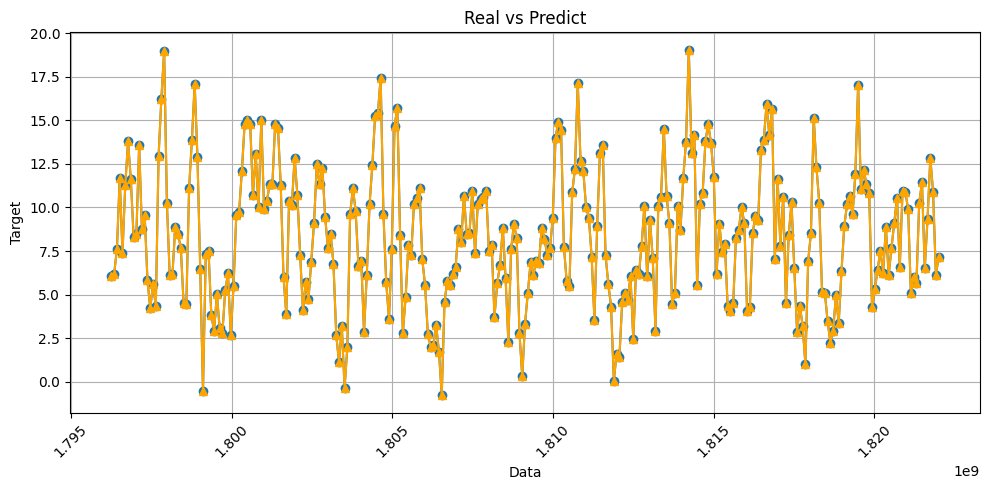

In [33]:
import matplotlib.pyplot as plt

# Temporal graph result
plt.figure(figsize=(10, 5))
plt.plot(test['data'], test['target'], marker='o', linestyle='-')
plt.plot(test['data'], loaded_estimator.predict(x_test), marker='^', linestyle='-', label='Inferência', color='orange')
plt.title('Real vs Predict')
plt.xlabel('Data')
plt.ylabel('Target')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()